In [1]:
from numpy import *

In [2]:
def loadSimpData():
    datMat = matrix([[ 1. ,  2.1],
        [ 2. ,  1.1],
        [ 1.3,  1. ],
        [ 1. ,  1. ],
        [ 2. ,  1. ]])
    classLabels = [1.0, 1.0, -1.0, -1.0, 1.0]
    return datMat,classLabels

In [3]:
def loadDataSet(fileName):      #general function to parse tab -delimited floats
    numFeat = len(open(fileName).readline().split('\t')) #get number of fields 
    dataMat = []; labelMat = []
    fr = open(fileName)
    for line in fr.readlines():
        lineArr =[]
        curLine = line.strip().split('\t')
        for i in range(numFeat-1):
            lineArr.append(float(curLine[i]))
        dataMat.append(lineArr)
        labelMat.append(float(curLine[-1]))
    return dataMat,labelMat

In [4]:
datMat, classLabels = loadSimpData()

In [5]:
datMat, classLabels 

(matrix([[1. , 2.1],
         [2. , 1.1],
         [1.3, 1. ],
         [1. , 1. ],
         [2. , 1. ]]),
 [1.0, 1.0, -1.0, -1.0, 1.0])

In [6]:
def stumpClassify(dataMatrix,dimen,threshVal,threshIneq):#just classify the data
    retArray = ones((shape(dataMatrix)[0],1))
    if threshIneq == 'lt':
        retArray[dataMatrix[:,dimen] <= threshVal] = -1.0
    else:
        retArray[dataMatrix[:,dimen] > threshVal] = -1.0
    return retArray

def buildStump(dataArr,classLabels,D):
    dataMatrix = mat(dataArr); labelMat = mat(classLabels).T
    m,n = shape(dataMatrix)
    numSteps = 10.0; bestStump = {}; bestClasEst = mat(zeros((m,1)))
    minError = inf #init error sum, to +infinity
    for i in range(n):#loop over all dimensions
        rangeMin = dataMatrix[:,i].min(); rangeMax = dataMatrix[:,i].max();
        stepSize = (rangeMax-rangeMin)/numSteps
        for j in range(-1,int(numSteps)+1):#loop over all range in current dimension
            for inequal in ['lt', 'gt']: #go over less than and greater than
                threshVal = (rangeMin + float(j) * stepSize)
                predictedVals = stumpClassify(dataMatrix,i,threshVal,inequal)#call stump classify with i, j, lessThan
                errArr = mat(ones((m,1)))
                errArr[predictedVals == labelMat] = 0
                weightedError = D.T*errArr  #calc total error multiplied by D
#                 print ("split: dim %d, thresh %.2f, thresh ineqal: %s, the weighted error is %.3f" % (i, threshVal, inequal, weightedError))
                if weightedError < minError:
                    minError = weightedError
                    bestClasEst = predictedVals.copy()
                    bestStump['dim'] = i
                    bestStump['thresh'] = threshVal
                    bestStump['ineq'] = inequal
    return bestStump,minError,bestClasEst

In [8]:
D = mat(ones((5, 1))/5)

In [9]:
buildStump(datMat, classLabels, D)

({'dim': 0, 'thresh': 1.3, 'ineq': 'lt'},
 matrix([[0.2]]),
 array([[-1.],
        [ 1.],
        [-1.],
        [-1.],
        [ 1.]]))

In [24]:
def adaBoostTrainDS(dataArr,classLabels,numIt=40):
    weakClassArr = []
    m = shape(dataArr)[0]
    D = mat(ones((m,1))/m)   #init D to all equal
    aggClassEst = mat(zeros((m,1)))
    for i in range(numIt):
        bestStump,error,classEst = buildStump(dataArr,classLabels,D)#build Stump
#         print ("D:",D.T)
        alpha = float(0.5*log((1.0-error)/max(error,1e-16)))#calc alpha, throw in max(error,eps) to account for error=0
        bestStump['alpha'] = alpha  
        weakClassArr.append(bestStump)                  #store Stump Params in Array
#         print ("classEst: ",classEst.T)
        expon = multiply(-1*alpha*mat(classLabels).T,classEst) #exponent for D calc, getting messy
        D = multiply(D,exp(expon))                              #Calc New D for next iteration
        D = D/D.sum()
        #calc training error of all classifiers, if this is 0 quit for loop early (use break)
        aggClassEst += alpha*classEst
#         print ("aggClassEst: ",aggClassEst.T)
        aggErrors = multiply(sign(aggClassEst) != mat(classLabels).T,ones((m,1)))
        errorRate = aggErrors.sum()/m
        print ("total error: ",errorRate)
        if errorRate == 0.0: break
    return weakClassArr,aggClassEst

In [11]:
adaBoostTrainDS(datMat, classLabels, 9)

D: [[0.2 0.2 0.2 0.2 0.2]]
classEst:  [[-1.  1. -1. -1.  1.]]
aggClassEst:  [[-0.69314718  0.69314718 -0.69314718 -0.69314718  0.69314718]]
total error:  0.2
D: [[0.5   0.125 0.125 0.125 0.125]]
classEst:  [[ 1.  1. -1. -1. -1.]]
aggClassEst:  [[ 0.27980789  1.66610226 -1.66610226 -1.66610226 -0.27980789]]
total error:  0.2
D: [[0.28571429 0.07142857 0.07142857 0.07142857 0.5       ]]
classEst:  [[1. 1. 1. 1. 1.]]
aggClassEst:  [[ 1.17568763  2.56198199 -0.77022252 -0.77022252  0.61607184]]
total error:  0.0


([{'dim': 0, 'thresh': 1.3, 'ineq': 'lt', 'alpha': 0.6931471805599453},
  {'dim': 1, 'thresh': 1.0, 'ineq': 'lt', 'alpha': 0.9729550745276565},
  {'dim': 0, 'thresh': 0.9, 'ineq': 'lt', 'alpha': 0.8958797346140273}],
 matrix([[ 1.17568763],
         [ 2.56198199],
         [-0.77022252],
         [-0.77022252],
         [ 0.61607184]]))

In [21]:
classLabels

[1.0, 1.0, -1.0, -1.0, 1.0]

In [12]:
def adaClassify(datToClass,classifierArr):
    dataMatrix = mat(datToClass)#do stuff similar to last aggClassEst in adaBoostTrainDS
    m = shape(dataMatrix)[0]
    aggClassEst = mat(zeros((m,1)))
    for i in range(len(classifierArr)):
        classEst = stumpClassify(dataMatrix,classifierArr[i]['dim'],\
                                 classifierArr[i]['thresh'],\
                                 classifierArr[i]['ineq'])#call stump classify
        aggClassEst += classifierArr[i]['alpha']*classEst
#         print (aggClassEst)
    return sign(aggClassEst)

In [13]:
weakClass, aggClassEst = adaBoostTrainDS(datMat, classLabels, 9)

D: [[0.2 0.2 0.2 0.2 0.2]]
classEst:  [[-1.  1. -1. -1.  1.]]
aggClassEst:  [[-0.69314718  0.69314718 -0.69314718 -0.69314718  0.69314718]]
total error:  0.2
D: [[0.5   0.125 0.125 0.125 0.125]]
classEst:  [[ 1.  1. -1. -1. -1.]]
aggClassEst:  [[ 0.27980789  1.66610226 -1.66610226 -1.66610226 -0.27980789]]
total error:  0.2
D: [[0.28571429 0.07142857 0.07142857 0.07142857 0.5       ]]
classEst:  [[1. 1. 1. 1. 1.]]
aggClassEst:  [[ 1.17568763  2.56198199 -0.77022252 -0.77022252  0.61607184]]
total error:  0.0


In [18]:
adaClassify(datMat[2],weakClass) == classLabels[2]

matrix([[ True]])

In [17]:
datMat, classLabels

(matrix([[1. , 2.1],
         [2. , 1.1],
         [1.3, 1. ],
         [1. , 1. ],
         [2. , 1. ]]),
 [1.0, 1.0, -1.0, -1.0, 1.0])

In [34]:
datArr, labelArr = loadDataSet('horseColicTraining2.txt')
classifierArray, aggClassEst = adaBoostTrainDS(datArr, labelArr, 10)

total error:  0.2842809364548495
total error:  0.2842809364548495
total error:  0.24749163879598662
total error:  0.24749163879598662
total error:  0.25418060200668896
total error:  0.2408026755852843
total error:  0.2408026755852843
total error:  0.22073578595317725
total error:  0.24749163879598662
total error:  0.23076923076923078


In [35]:
testArr, testLabelArr = loadDataSet('horseColicTest2.txt')
prediction10 = adaClassify(testArr, classifierArray)
errArr = mat(ones((shape(testArr)[0], 1)))
errArr[prediction10 == mat(testLabelArr).T] = 0
err_rate = errArr.sum()/shape(testArr)[0]

In [36]:
err_rate

0.23880597014925373

In [37]:
def plotROC(predStrengths, classLabels):
    import matplotlib.pyplot as plt
    cur = (1.0,1.0) #cursor
    ySum = 0.0 #variable to calculate AUC
    numPosClas = sum(array(classLabels)==1.0)
    yStep = 1/float(numPosClas); xStep = 1/float(len(classLabels)-numPosClas)
    sortedIndicies = predStrengths.argsort()#get sorted index, it's reverse
    fig = plt.figure()
    fig.clf()
    ax = plt.subplot(111)
    #loop through all the values, drawing a line segment at each point
    for index in sortedIndicies.tolist()[0]:
        if classLabels[index] == 1.0:
            delX = 0; delY = yStep;
        else:
            delX = xStep; delY = 0;
            ySum += cur[1]
        #draw line from cur to (cur[0]-delX,cur[1]-delY)
        ax.plot([cur[0],cur[0]-delX],[cur[1],cur[1]-delY], c='b')
        cur = (cur[0]-delX,cur[1]-delY)
    ax.plot([0,1],[0,1],'b--')
    plt.xlabel('False positive rate'); plt.ylabel('True positive rate')
    plt.title('ROC curve for AdaBoost horse colic detection system')
    ax.axis([0,1,0,1])
    plt.show()
    print ("the Area Under the Curve is: ",ySum*xStep)

total error:  0.2842809364548495
total error:  0.2842809364548495
total error:  0.24749163879598662
total error:  0.24749163879598662
total error:  0.25418060200668896
total error:  0.2408026755852843
total error:  0.2408026755852843
total error:  0.22073578595317725
total error:  0.24749163879598662
total error:  0.23076923076923078


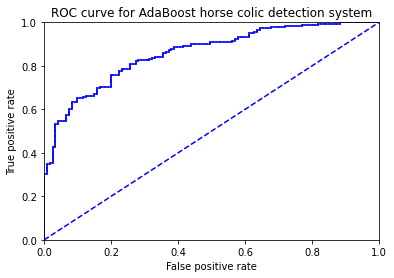

the Area Under the Curve is:  0.8582969635063604


In [38]:
datArr, labelArr = loadDataSet('horseColicTraining2.txt')
classifierArray, aggClassEst = adaBoostTrainDS(datArr, labelArr, 10)
plotROC(aggClassEst.T, labelArr)

matrix([[0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],

In [92]:
sortIndex = (aggClassEst.T).argsort()

In [93]:
sortIndex

matrix([[ 45,  59, 244, 230, 141,  40, 272,  35, 181,  83, 239, 192,  49,
         133,  46, 176, 121, 285,  30, 296, 227,  16, 150, 252, 101, 108,
          44, 173,  80,  58,  37,   4, 256, 225, 280, 172, 170, 270, 204,
         178, 295, 246,   0, 216, 168, 162, 291,  43, 253,  97,  99,  19,
         249, 184,   8,  86, 271, 245,  34, 179, 134,  15, 219, 229, 126,
          62, 159, 281, 221, 110, 274,  73, 234,  36, 262, 123, 200, 147,
         177,  63, 140,  48, 290, 196, 135,  78, 203, 238,  93, 210,  42,
          31,  75,  57, 247,  20, 254, 190, 113, 261,  72, 282, 195,  79,
           9, 171, 294, 128, 209, 151, 164,  66,  70,  68,  54, 258,  91,
         251,  64, 109,  82, 198,   3,  39,  25, 286,  41, 297,  55, 292,
         237,  10, 167, 104,  18, 193, 265, 207, 143, 273, 114,  90, 205,
         118, 102, 127, 259, 106,  26, 232, 131,   1, 117, 250, 266, 241,
         180, 174, 231, 287, 226, 206, 215, 298,  87,  74,  56, 160,  53,
         130,  28,  17, 188, 161,   7,

In [101]:
aggClassEst[116]

matrix([[1.99797044]])